In [1]:
import pandas as pd
import numpy as np
from typing import List, Dict, Any

from src.build_network import ResIN
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
from adjustText import adjust_text

import yaml
with open("../../src/configs.yml", "r") as configs:
    configs = yaml.safe_load(configs)

ROOTPATH = configs["ROOTPATH"]
ROOTPATH2 = configs["ROOTPATH2"]
OUTPATH = "../../output/results-summary-092924/"

print(configs)

{'ROOTPATH': '/Users/yijingch/Documents/GITHUB/broken-egg-polarization/', 'GITHUBPATH': '/Users/yijingch/Documents/GITHUB/', 'ROOTPATH2': '/Users/yijingch/Dropbox/CSS 2023 Attitude Networks/ANES/Cumulative'}


In [2]:
anes_all = pd.read_csv(ROOTPATH + "data/anes_out_092924.csv").drop(columns=["Unnamed: 0"])
YEARS = [2000, 2004, 2008, 2012, 2016, 2020]
anes_all = anes_all[anes_all["year"].isin(YEARS)]
anes_all["ft_rep_net"] = anes_all["ft_rep"] - anes_all["ft_dem"] # compute the net value of ft rep/dem
anes_all = anes_all[anes_all["dem_rep_7"].notna()]
anes_all.head()
len(anes_all)

23651

In [3]:
NODE_COLS = [
    "spend_serv", "gov_health", "guar_jobs", "abort", "aid_black",
]

# COV_COLS = ["ft_rep_net"]
COV_COLS = ["dem_rep_7"]

In [4]:
RESIN_DICT = {}
NEUTRAL_VAL_DICT = {}
for year in YEARS:
    print("processing:", year)
    anes_year = anes_all[anes_all["year"]==year].copy()
    anes_year = anes_year[NODE_COLS + COV_COLS]
    resin = ResIN(df=anes_year, node_cols=NODE_COLS)
    resin.make_graph(square_corr=False, remove_nan=True)
    resin.compute_covariates(covariate_cols=COV_COLS)
    resin.adjust_coordinates()
    resin.get_item_size()
    resin.set_edge_distance()
    RESIN_DICT[year] = resin
    # NEUTRAL_VAL_DICT[year] = np.nanmean(anes_year["ft_rep_net"])

processing: 2000
processing: 2004
processing: 2008
processing: 2012
processing: 2016
processing: 2020


In [5]:
YEARS_TO_FLIP = [2004, 2020]
for y in YEARS_TO_FLIP:
    RESIN_DICT[y].left_right_flip()

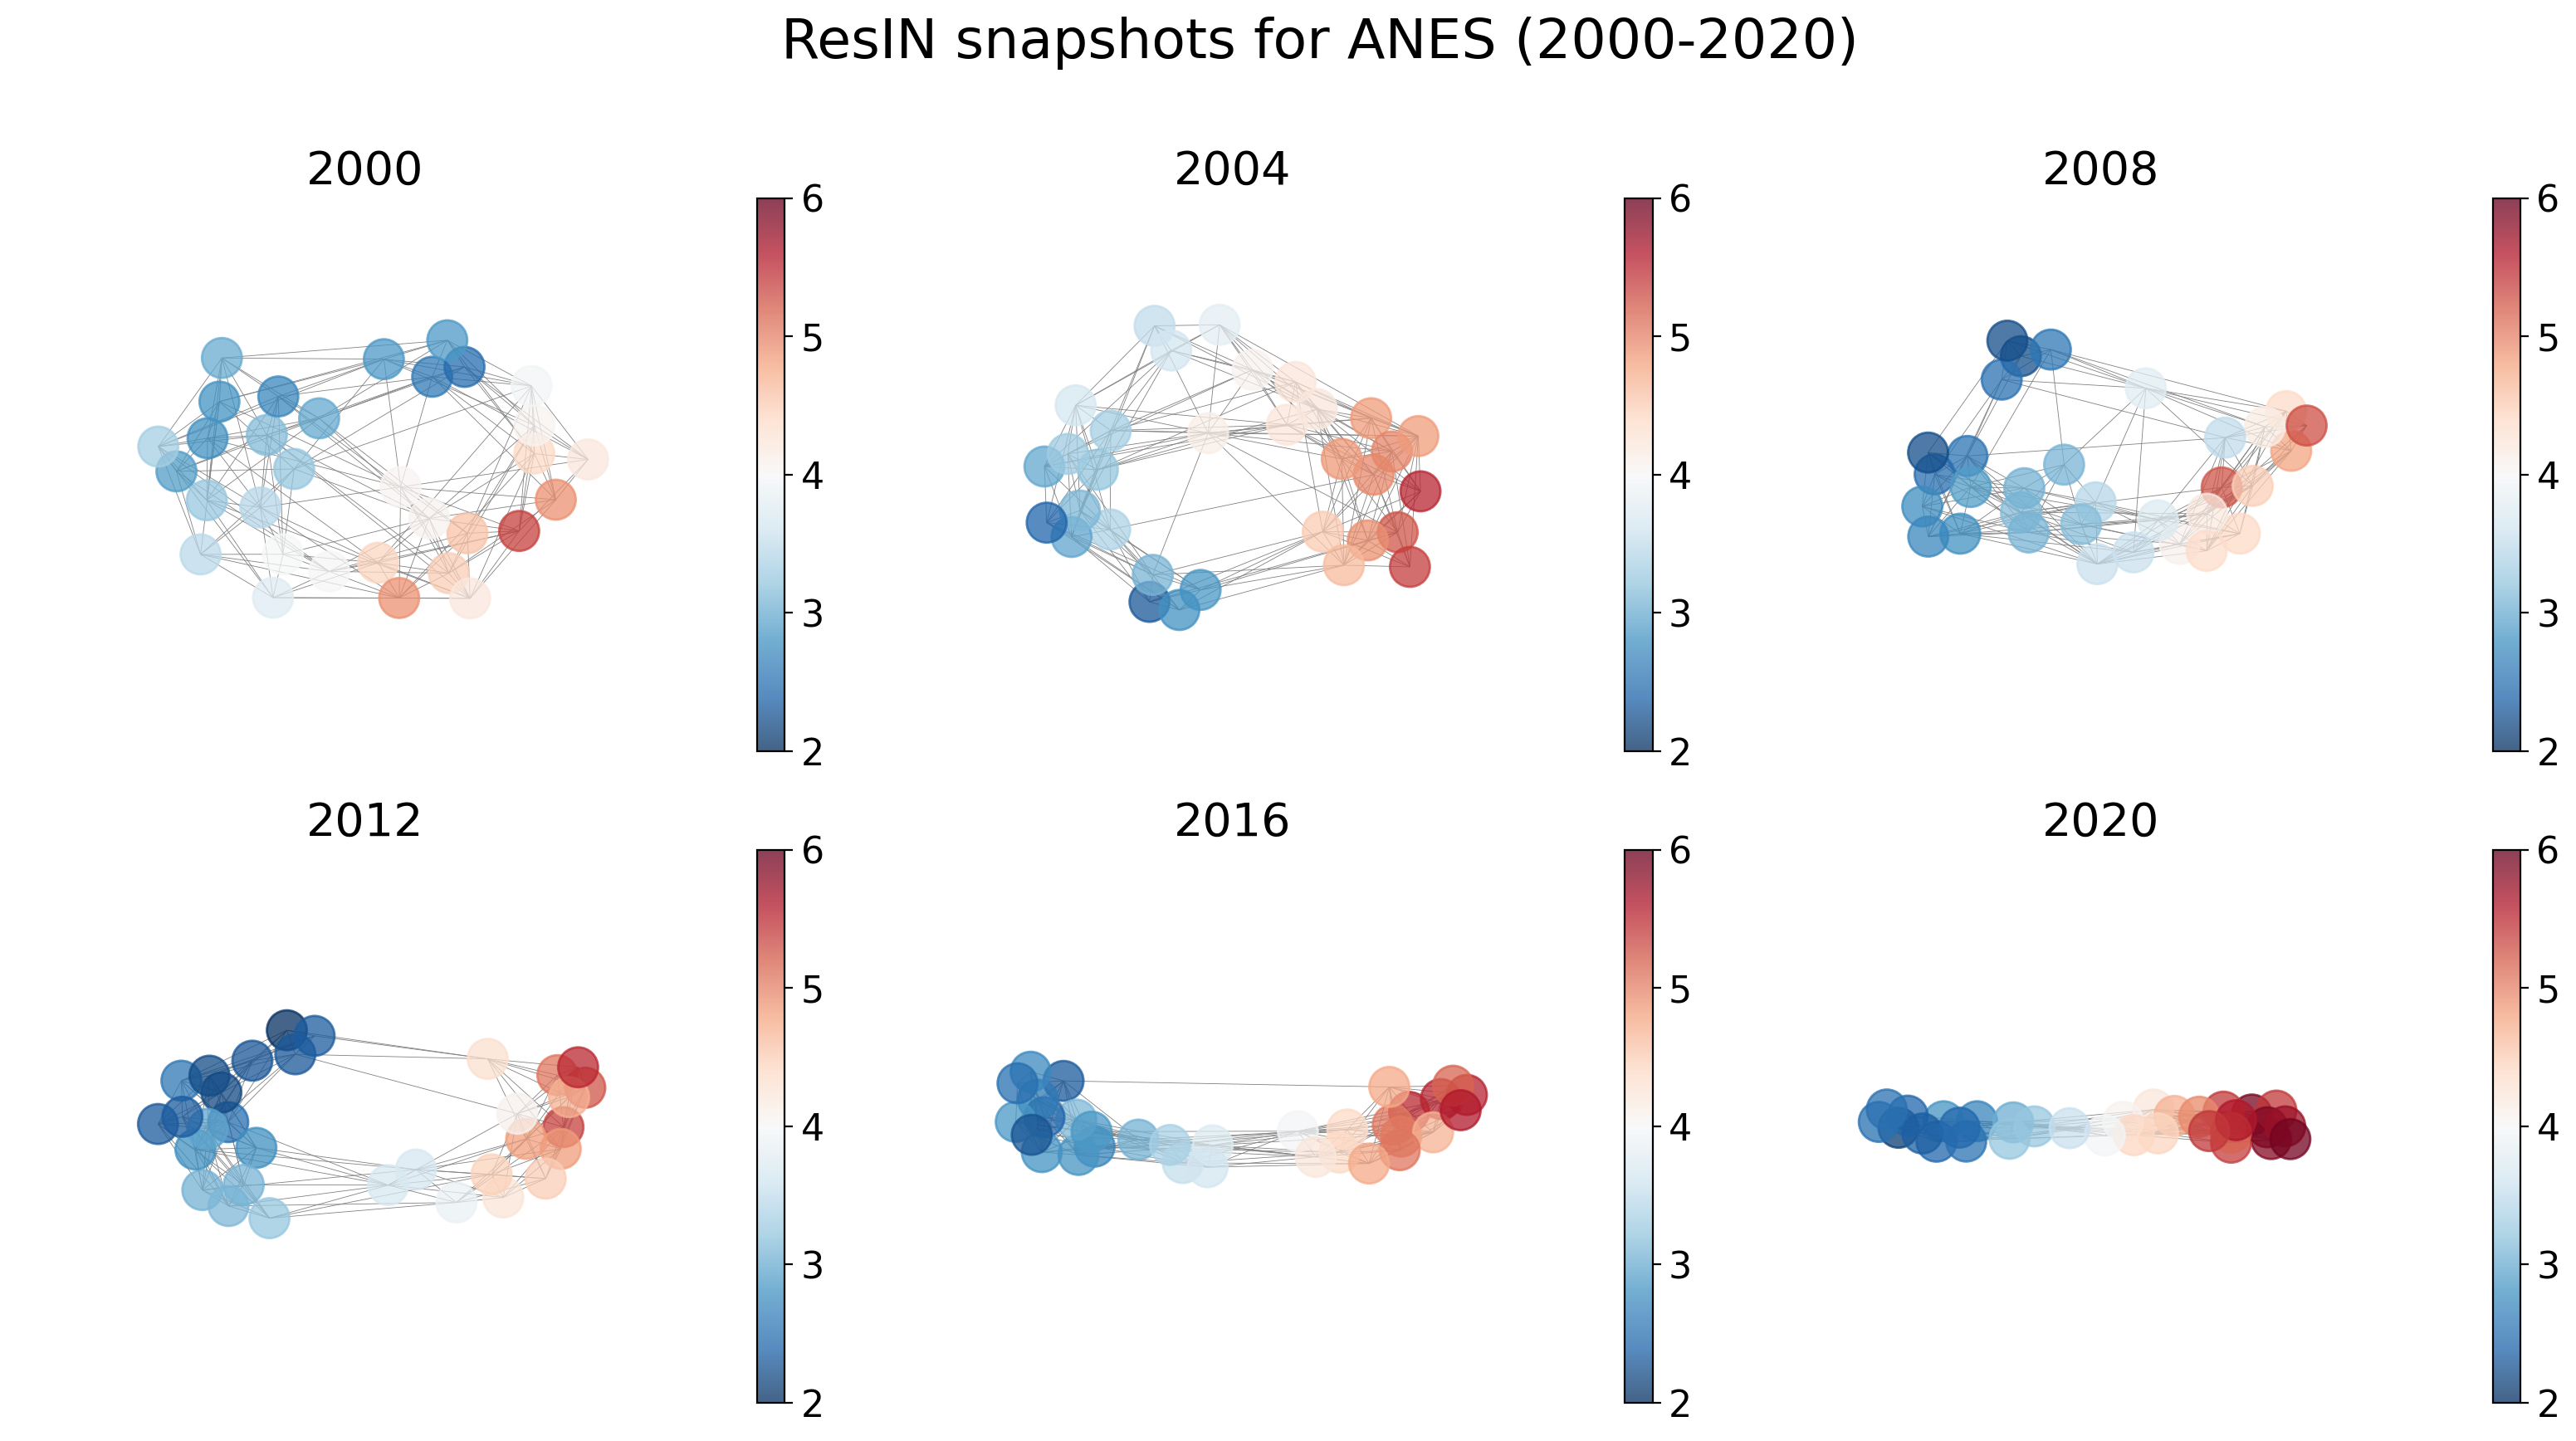

In [6]:
from sklearn.preprocessing import MinMaxScaler

color_var = COV_COLS[0]
fig,ax = plt.subplots(ncols=3, nrows=2, figsize=(16,8))
ax = [x for ls in ax for x in ls]

for i, (year,resin) in enumerate(RESIN_DICT.items()):
    NEUTRAL_VAL = 0
    # colors = [distinguish_operational_symbolic(x) for x in list(resin.g.nodes())]
    colors = [resin.node_attrs[color_var][x] for x in resin.g.nodes()]
    color_bound = max([NEUTRAL_VAL-min(colors), max(colors)-NEUTRAL_VAL])
    sizes = np.array([resin.node_attrs["size"][x] for x in resin.g.nodes()]).reshape(-1,1)
    scaler = MinMaxScaler().fit(sizes)
    sizes = scaler.transform(sizes).reshape(-1)
    sizes = sizes*2000**1/2

    nodes_plot = nx.draw_networkx_nodes(
        resin.g, ax=ax[i], 
        pos=resin.pos_new, 
        # node_size=sizes,
        node_color=colors, 
        # node_color="lightgrey",
        cmap="RdBu_r", 
        alpha=.75, label=False,
        # vmin=NEUTRAL_VAL-color_bound, vmax=NEUTRAL_VAL+color_bound,  # if not normalizing colorbar
        vmin=2, vmax=6
        ) 
    edges_plot = nx.draw_networkx_edges(
        resin.g, ax=ax[i], edge_color="grey", pos=resin.pos_new, width=.3,
    )
    # nx.draw_networkx_labels(resin.g, ax=ax[i], pos=resin.pos_new)
    ax[i].set_title(year, fontsize=20)
    clb = plt.colorbar(nodes_plot)
    clb.ax.tick_params(labelsize=16)
    ax[i].set_ylim(-1.65, 1.65)
    ax[i].set_xlim(-1.65, 1.65)
    ax[i].axis("off")
plt.tight_layout()
plt.suptitle(f"ResIN snapshots for ANES (2000-2020)", fontsize=24, y=1.08)
plt.savefig(OUTPATH + f"anes_resin_snapshot_2000_2020_pid7.pdf", dpi=300, bbox_inches="tight")